# Generating fake Donald Trump tweet

For the purpose of a lab work, we need to build fake Donald Trump tweet. The goal of the lab work will be to build a classifier *Donald Trump or AI ?*.
We will build upon a kaggle dataset composed of thousands of tweets from Donald Trump until its ban.

In [118]:
import pandas as pd

df = pd.read_csv("realdonaldtrump.csv")
df = df[["content"]]
df.head()

,content
0,Be sure to tune in and watch Donald Trump on L...
1,Donald Trump will be appearing on The View tom...
2,Donald Trump reads Top Ten Financial Tips on L...
3,New Blog Post: Celebrity Apprentice Finale and...
4,"""My persona will never be that of a wallflower..."


Let's inspect randomly some tweets:

In [119]:
from random import randint


for _ in range(10):
    index = randint(0, df.shape[0])
    print(df["content"][index])
    print("-" * 25)

So interesting that, when I announced Trump National Doral in Miami would be used for the hosting of the G-7, and then rescinded due to Do Nothing Democrat/Fake News Anger, very few in Media mentioned that NO PROFITS would be taken, or would be given FREE, if legally permissible!
-------------------------
Australia, New Zealand, and more. I am always available to them. @ nytimes is just upset that they looked like fools in their coverage of me.
-------------------------
Obama is angry, frustrated and desperate. He said “voting is the best revenge” http://bit.ly/Ykwd44 He is divisive.
-------------------------
The NFL players are at it again - taking a knee when they should be standing proudly for the National Anthem. Numerous players, from different teams, wanted to show their “outrage” at something that most of them are unable to define. They make a fortune doing what they love......
-------------------------
As per recent Federal Court ruling, the Federal Government will be withholdi

There are some things we can notice :
* Sometimes there a quotes, we do not want to copy the style of these tweets. We can identy them with the double quote caracter and self @.
* We do not want to keep tweet with url inside
* We do not want to keep tweet with picture, that we cannot *use* here

In [120]:
df["quote"] = df["content"].apply(lambda string : "\" " in string)
df["trump"] = df["content"].apply(lambda string: "@ realDonaldTrump" in string)
df["url"] = df["content"].apply(lambda string: ("http://" in string) or ("https://" in string))
df["picture"] = df["content"].apply(lambda string: "pic.twitter.com" in string)

print("Initial:\t\t\t", df.shape)
df = df.loc[~df["trump"], ]
print("Deleted tweets with self@:\t", df.shape)
df = df.loc[~df["quote"], ]
print("Deleted tweets with quotes:\t", df.shape)
df = df.loc[~df["url"], ]
print("Deleted tweets with URL:\t", df.shape)
df = df.loc[~df["picture"], ]
print("Deleted tweets with picture:\t", df.shape)
df = df.reset_index(drop=True)


Initial:			 (43352, 5)
Deleted tweets with self@:	 (34908, 5)
Deleted tweets with quotes:	 (31070, 5)
Deleted tweets with URL:	 (23874, 5)
Deleted tweets with picture:	 (21521, 5)


We would like to have a bit of homogenous tweets, let's inspect.

In [121]:
df["length"] = df["content"].apply(lambda string: len(string))
df["word_count"] = df["content"].apply(lambda string: len(string.split()))

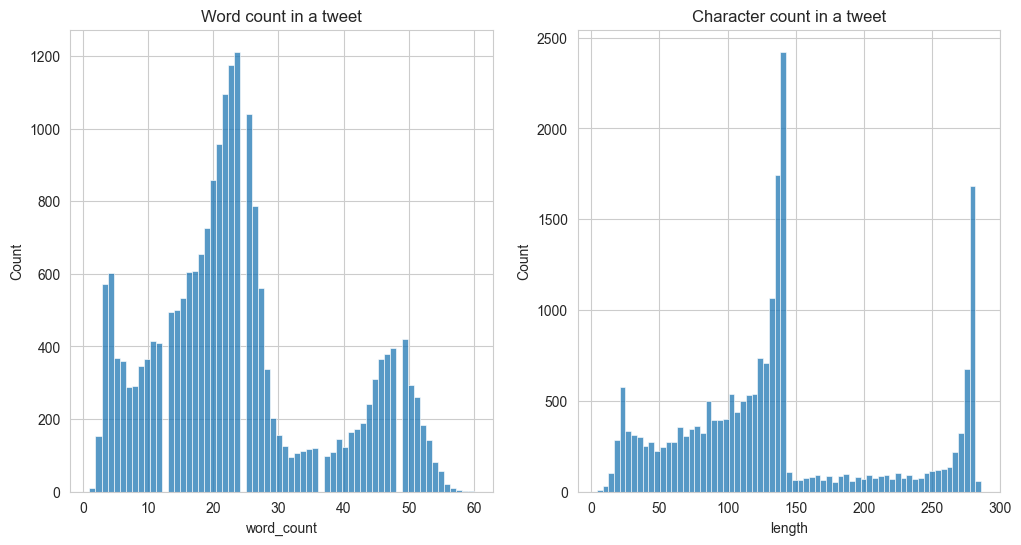

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style(style="whitegrid")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x="word_count")
plt.title("Word count in a tweet")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="length")
plt.title("Character count in a tweet")

plt.show()

We will stick with the old limit of 150 caracter and tweets with more than 10 words.

In [123]:
print(df.shape)
df = df.loc[(df["length"] <= 150) & (df["word_count"] >= 10), ]
df = df.reset_index(drop=True)
print(df.shape)

(21521, 7)
(13235, 7)


## Generation

We have a curated dataset, we now need to generate tweet. We'll use LangChain framework for this. We will use a real tweet as an example and as inspiration.

In [112]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

model = "deepseek-r1:1.5b"
model = OllamaLLM(model=model)

prompt_template = PromptTemplate(
    template="""
    You are an assistant for president Donald Trump twitter/X account. You need to write tweets just like Donald Trump. You will be given an example tweet wrote by him for example, write about the same subject.
    RULES: WRITE ONLY THE TWEET AND NOTHING ELSE, KEEP IT SHORT UNDER 150 CHARACTERS
    
    Example tweet: {example}
    Tweet:
    """,
    input_variables=["example"]
)

chain = (
    {"example": RunnablePassthrough()}
    | prompt_template
    | model
    | StrOutputParser()
)

We can change the model in the previous cell and launch the next cell so that we can have tweets generated by different models.

In [125]:
from tqdm import tqdm 
import time

n = 25
tweets = []

for _ in tqdm(range(n)):
    index = randint(0, df.shape[0])
    tweet = df["content"][index]
    fake_tweet = chain.invoke(tweet)
    tweets.append(fake_tweet)

dataframe = pd.DataFrame({
    "model": model.model,
    "content": tweets
})

name = time.strftime("%Y%m%d_%H%M%S")
dataframe.to_csv(f"Generated_tweets/{name}.csv", index=False)


  0%|          | 0/25 [00:04<?, ?it/s]


KeyboardInterrupt: 

## Final dataset

Given several files, we will create a balanced dataset from it.

In [130]:
from os import listdir

dataframes = []
for filepath in listdir(path="Generated_tweets"):
    dataframe = pd.read_csv(f"Generated_tweets/{filepath}")
    dataframes.append(dataframe)

dataframe = pd.concat(dataframes)
dataframe["generated"] = 1
dataframe["model"].value_counts()

model
gemma3:4b           3500
llama3.2:3b         3000
qwen2.5:3b          2000
deepseek-r1:1.5b     300
Name: count, dtype: int64

But not all models wrote 150 character tweets. Therefore we filter it :

In [131]:
def compute_length(string):
    if len(string) == 0:
        return 200
    elif ("<think>" in string) and ("</think>" in string):
        tweet = string.split("</think>")[1]
        return(len(tweet.strip()))
    else:
        return len(string)


dataframe["length"] = dataframe["content"].apply(lambda string: compute_length(string))

dataframe = dataframe.loc[dataframe["length"] <= 150, ]
dataframe["model"].value_counts()

model
gemma3:4b           2992
llama3.2:3b         1531
qwen2.5:3b          1115
deepseek-r1:1.5b     252
Name: count, dtype: int64

We now need to downsample the original dataset in order to get a balanced dataset for the classification.

In [132]:
from random import sample
size = dataframe.shape[0]
indexes = sample(range(size), k=size)
df = df.iloc[indexes, ]
df = df[["content"]]
df["generated"] = 0
df.reset_index(inplace=True, drop=True)

Given the two previous built dataset, we can finally close this notebook.

In [133]:
final = pd.concat((df, dataframe[["content", "generated", "model"]]))
final.to_csv("Donald_or_AI.csv", index=False)